In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os


In [1]:
datapath="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/data"
outputlabelbinarizer="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/model/videoclassificationbinarizer"
outputmodel="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/output/videoclassificationmodel"
epoch=25
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["iron_pillar", "qutub_minar","alai_darwaza"])


In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

[INFO] loading images...


In [5]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


In [6]:
data = np.array(data)
labels = np.array(labels)


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)


In [9]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [10]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = vgg16.VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [11]:

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [12]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epoch)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [13]:
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=epoch)


[INFO] training head...
Epoch 1/25
20/20 [==============================] - 162s 8s/step - loss: 4.0278 - accuracy: 0.4446 - val_loss: 2.1981 - val_accuracy: 0.5990
Epoch 2/25
20/20 [==============================] - 167s 8s/step - loss: 2.6529 - accuracy: 0.5762 - val_loss: 1.3006 - val_accuracy: 0.7292
Epoch 3/25
20/20 [==============================] - 167s 8s/step - loss: 1.8750 - accuracy: 0.6372 - val_loss: 1.1353 - val_accuracy: 0.7708
Epoch 4/25
20/20 [==============================] - 166s 8s/step - loss: 1.4340 - accuracy: 0.6902 - val_loss: 0.9669 - val_accuracy: 0.8125
Epoch 5/25
20/20 [==============================] - 163s 8s/step - loss: 1.2378 - accuracy: 0.7063 - val_loss: 0.9673 - val_accuracy: 0.8177
Epoch 6/25
20/20 [==============================] - 163s 8s/step - loss: 1.0237 - accuracy: 0.7576 - val_loss: 1.0846 - val_accuracy: 0.7656
Epoch 7/25
20/20 [==============================] - 163s 8s/step - loss: 1.0205 - accuracy: 0.7432 - val_loss: 0.8524 - val_accura

In [14]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)



[INFO] evaluating network...


In [17]:
print(classification_report(
	testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_, digits = 6))
print(testY.argmax(axis=1))

              precision    recall  f1-score   support

alai_darwaza   0.769231  0.967742  0.857143        31
 iron_pillar   0.833333  0.833333  0.833333        96
 qutub_minar   0.869048  0.793478  0.829545        92

    accuracy                       0.835616       219
   macro avg   0.823871  0.864851  0.840007       219
weighted avg   0.839263  0.835616  0.835112       219

[0 1 1 0 1 1 2 1 2 1 0 0 1 1 0 2 2 2 1 1 2 2 1 0 1 2 2 2 1 1 2 2 1 2 2 2 1
 2 0 1 2 2 1 2 2 0 2 1 1 1 2 1 2 1 1 2 1 0 2 0 0 1 1 1 1 1 1 0 2 0 1 2 2 1
 2 1 2 2 2 1 1 1 0 1 1 0 2 2 0 0 2 1 2 2 0 0 0 2 2 1 1 0 1 2 1 1 1 0 2 0 2
 1 1 1 2 1 1 2 1 1 0 2 2 2 2 2 1 2 1 2 1 1 2 1 2 1 1 2 2 2 1 2 2 1 1 2 2 2
 1 1 2 1 0 1 1 0 2 1 2 1 2 2 1 2 2 2 1 0 1 2 0 1 1 2 2 0 1 2 2 1 2 2 1 2 1
 1 2 2 1 1 1 2 2 2 2 1 2 1 0 1 2 1 2 1 1 2 1 1 1 2 2 2 1 1 2 1 2 0 1]


In [18]:
from collections import Counter
Counter(testY.argmax(axis=1))
Counter(predictions.argmax(axis=1))

Counter({0: 39, 1: 96, 2: 84})

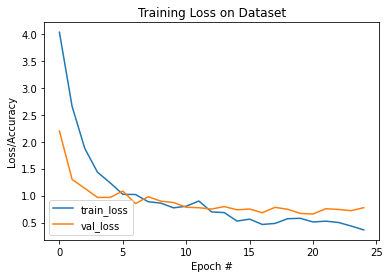

In [19]:
plt.figure()
plt.plot( H.history["loss"], label="train_loss")
plt.plot( H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()  

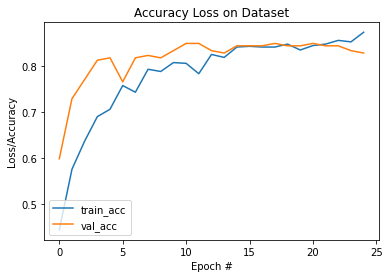

In [20]:
plt.figure()
plt.plot( H.history["accuracy"], label="train_acc")
plt.plot( H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()
